In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                           f1_score, roc_curve, auc, roc_auc_score)
import shap
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [6]:
# Load the dataset
df = pd.read_csv('bank.csv', delimiter=';')
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\n" + "="*80)

Dataset shape: (4521, 17)

First few rows:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  



In [8]:
# Basic dataset info
print("Dataset Information:")
print(df.info())
print("\n" + "="*80)

print("\nColumn names:")
print(df.columns.tolist())
print("\n" + "="*80)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None


Column names:
['age', 'job', 'marital', 'education', 'default', 'balanc

In [10]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print("\n" + "="*80)

Missing values per column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64



In [12]:
# Statistical summary
print("Statistical summary:")
print(df.describe())
print("\n" + "="*80)

# Target variable distribution
print("\nTarget variable (y) distribution:")
print(df['y'].value_counts())
print(f"\nPercentage: \n{df['y'].value_counts(normalize=True) * 100}")
print("\n" + "="*80)

Statistical summary:
               age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000

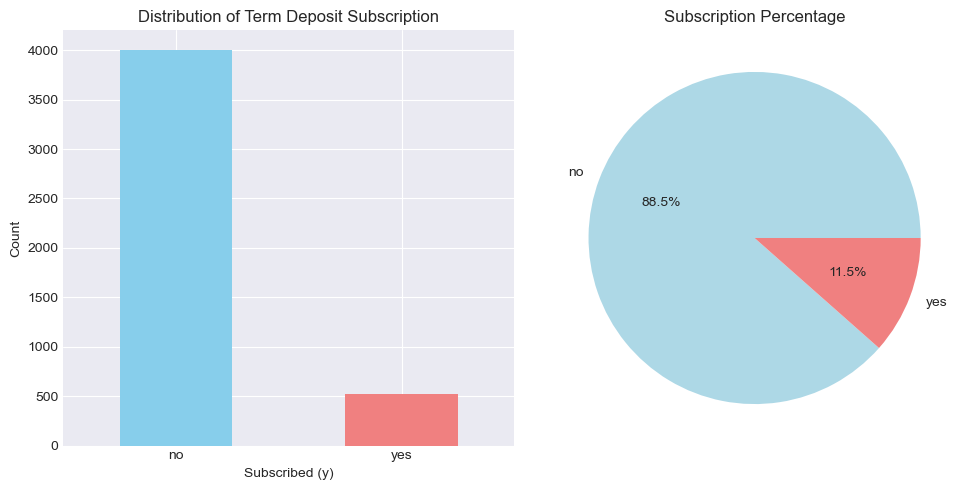

In [14]:
# Visualize target distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['y'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Term Deposit Subscription')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['y'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', 
                                          colors=['lightblue', 'lightcoral'])
plt.title('Subscription Percentage')
plt.ylabel('')
plt.tight_layout()
plt.show()

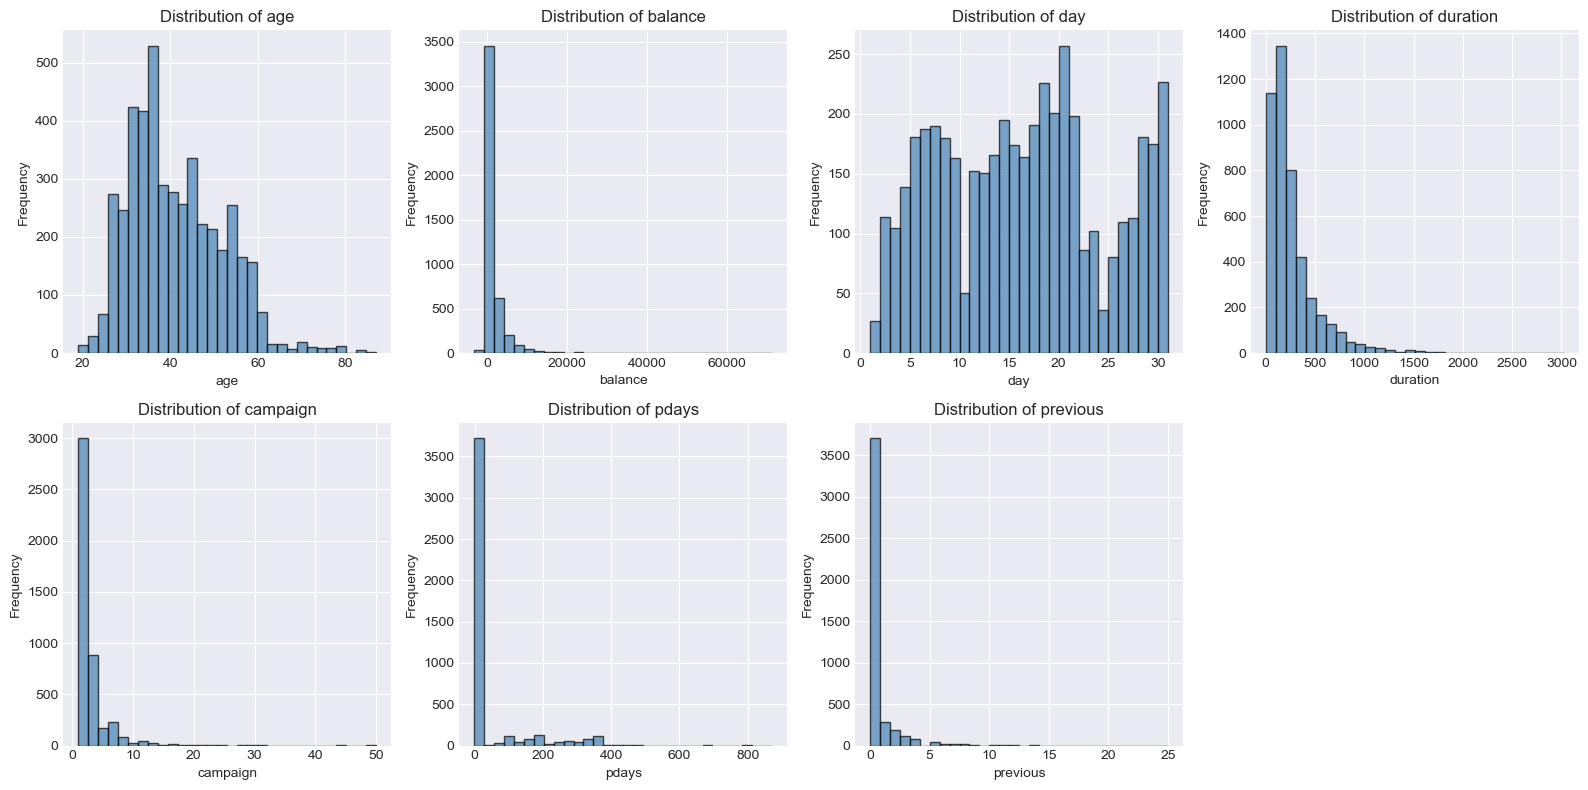

In [16]:
# Distribution of numerical features
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    if idx < len(axes):
        axes[idx].hist(df[col], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

# Remove empty subplots
for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [20]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values if any (for pdays=-1, which means not contacted)
df_processed['pdays'] = df_processed['pdays'].replace(-1, np.nan)
df_processed['previous'] = df_processed['previous'].replace(0, np.nan)

# Separate features and target
X = df_processed.drop('y', axis=1)
y = df_processed['y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")

Training set size: (3616, 16)
Test set size: (905, 16)

Training target distribution:
y
no     3199
yes     417
Name: count, dtype: int64

Test target distribution:
y
no     801
yes    104
Name: count, dtype: int64


In [22]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [24]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Create preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Fit and transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
categorical_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
categorical_features = categorical_encoder.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, categorical_features])

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")
print(f"Number of features: {len(all_feature_names)}")

Processed training data shape: (3616, 51)
Processed test data shape: (905, 51)
Number of features: 51


In [26]:
# Convert target to binary
y_train_binary = (y_train == 'yes').astype(int)
y_test_binary = (y_test == 'yes').astype(int)

print(f"Target conversion complete:")
print(f"Training: {np.sum(y_train_binary)} positives out of {len(y_train_binary)}")
print(f"Test: {np.sum(y_test_binary)} positives out of {len(y_test_binary)}")

Target conversion complete:
Training: 417 positives out of 3616
Test: 104 positives out of 905


In [28]:
# Model 1: Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg.fit(X_train_processed, y_train_binary)

# Model 2: Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_processed, y_train_binary)

print("Models trained successfully!")

Models trained successfully!


In [30]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance"""
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities for ROC curve
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{'='*60}")
    print(f"EVALUATION FOR {model_name}")
    print(f"{'='*60}")
    
    # Confusion Matrix
    print(f"\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm, 
                         index=['Actual No', 'Actual Yes'], 
                         columns=['Predicted No', 'Predicted Yes'])
    print(cm_df)
    
    # Classification Report
    print(f"\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, 
                                target_names=['No', 'Yes']))
    
    # F1-Score
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    print(f"F1-Score - Train: {train_f1:.4f}, Test: {test_f1:.4f}")
    
    # AUC-ROC Score
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    print(f"AUC-ROC - Train: {train_auc:.4f}, Test: {test_auc:.4f}")
    
    return {
        'model': model,
        'y_test_pred': y_test_pred,
        'y_test_prob': y_test_prob,
        'cm': cm,
        'test_f1': test_f1,
        'test_auc': test_auc
    }

In [32]:
# Evaluate both models
logreg_results = evaluate_model(logreg, X_train_processed, X_test_processed, 
                                y_train_binary, y_test_binary, "LOGISTIC REGRESSION")
rf_results = evaluate_model(rf, X_train_processed, X_test_processed, 
                           y_train_binary, y_test_binary, "RANDOM FOREST")


EVALUATION FOR LOGISTIC REGRESSION

Confusion Matrix (Test Set):
            Predicted No  Predicted Yes
Actual No            665            136
Actual Yes            23             81

Classification Report (Test Set):
              precision    recall  f1-score   support

          No       0.97      0.83      0.89       801
         Yes       0.37      0.78      0.50       104

    accuracy                           0.82       905
   macro avg       0.67      0.80      0.70       905
weighted avg       0.90      0.82      0.85       905

F1-Score - Train: 0.5555, Test: 0.5047
AUC-ROC - Train: 0.9097, Test: 0.8907

EVALUATION FOR RANDOM FOREST

Confusion Matrix (Test Set):
            Predicted No  Predicted Yes
Actual No            723             78
Actual Yes            37             67

Classification Report (Test Set):
              precision    recall  f1-score   support

          No       0.95      0.90      0.93       801
         Yes       0.46      0.64      0.54       1

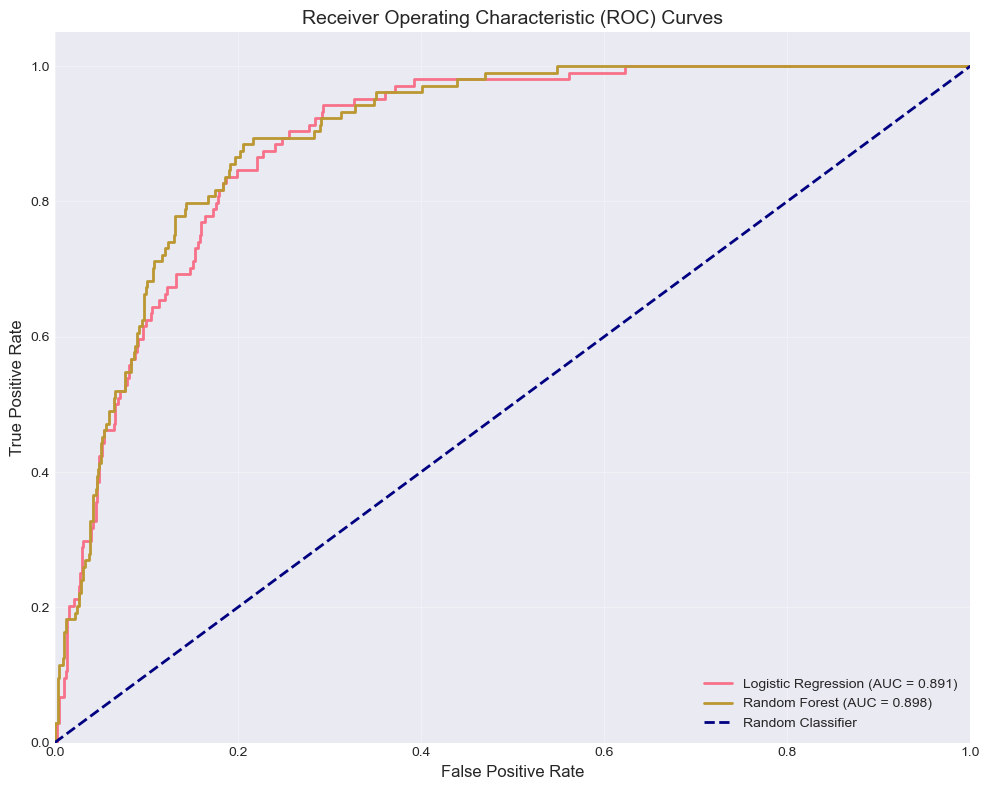

In [34]:
def plot_roc_curves(models_results):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for model_name, results in models_results.items():
        y_test_prob = results['y_test_prob']
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test_binary, y_test_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, 
                label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot ROC curves
plot_roc_curves({
    'Logistic Regression': logreg_results,
    'Random Forest': rf_results
})

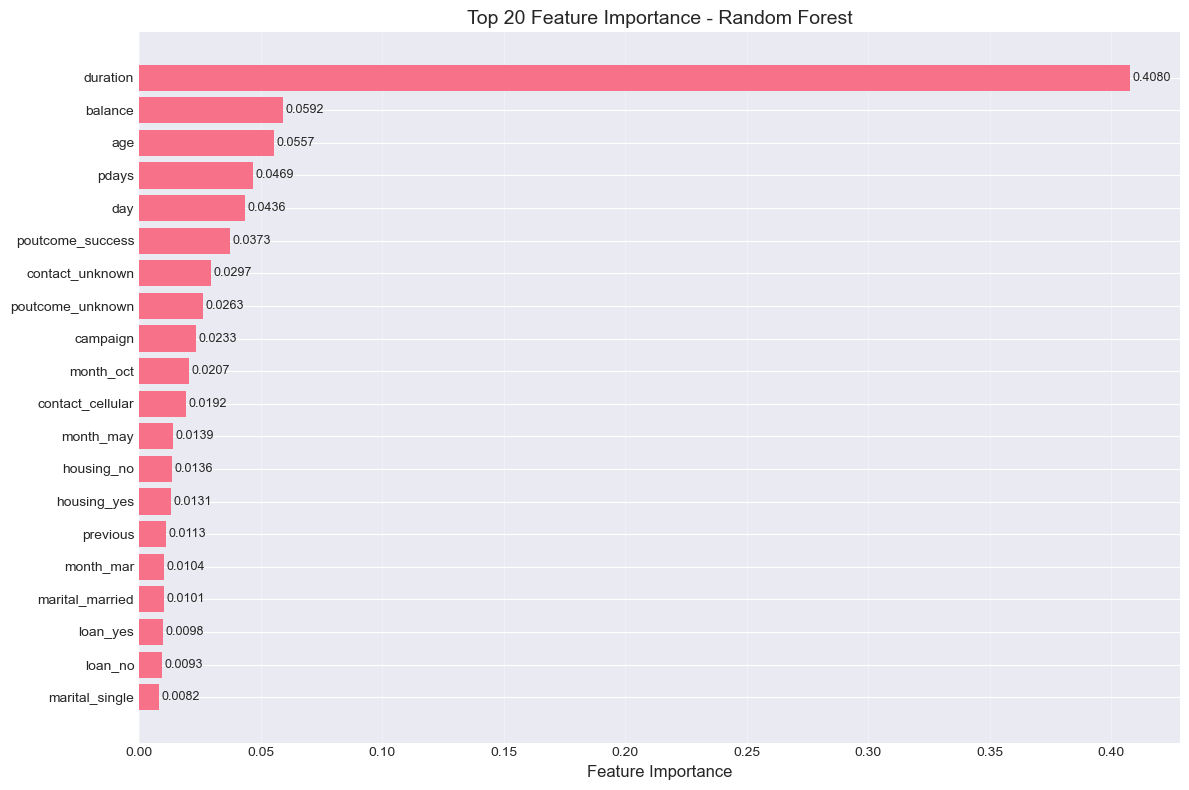

In [36]:
# Feature importance from Random Forest
feature_importance = rf.feature_importances_

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False).head(20)

# Plot top features
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['feature'][::-1], importance_df['importance'][::-1])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Feature Importance - Random Forest', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (value, bar) in enumerate(zip(importance_df['importance'][::-1], bars)):
    plt.text(value + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{value:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Type of shap_values: <class 'shap._explanation.Explanation'>
Shape of shap_values.values: (100, 51, 2)
Shape of X_test_sample: (100, 51)
Number of features: 51


<Figure size 1200x800 with 0 Axes>

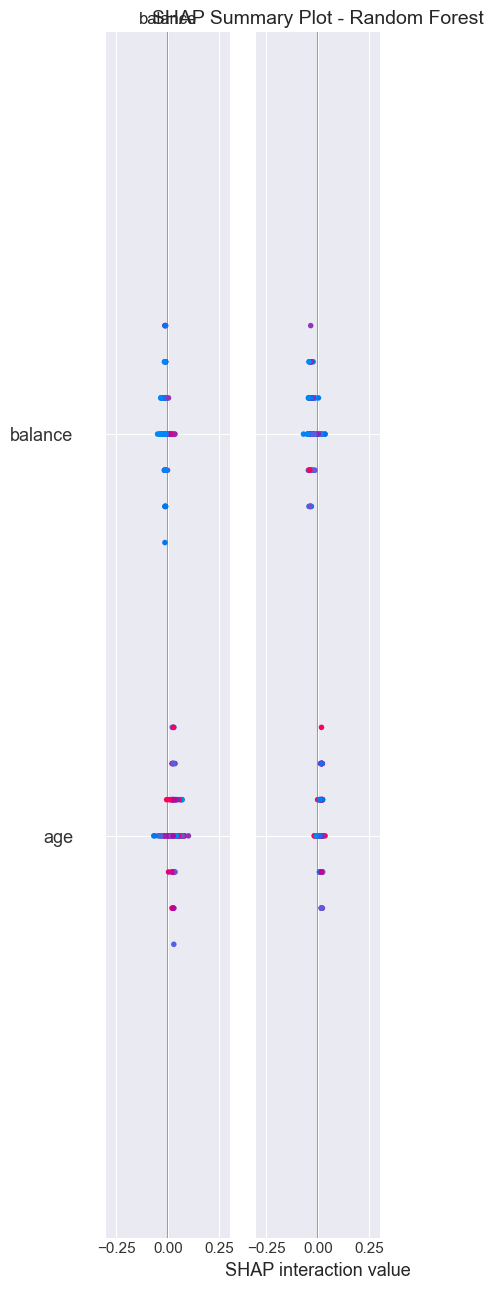

In [40]:
# Initialize SHAP explainer
explainer_shap = shap.TreeExplainer(rf)

# Calculate SHAP values for a sample of the test set
sample_idx = np.random.choice(X_test_processed.shape[0], min(100, X_test_processed.shape[0]), replace=False)
X_test_sample = X_test_processed[sample_idx]

# Get SHAP values - handle binary classification properly
shap_values = explainer_shap(X_test_sample)

# Check the structure of shap_values
print(f"Type of shap_values: {type(shap_values)}")

# For binary classification, shap_values should have shape (n_samples, n_features)
# If it's a list, we need to extract the correct values
if isinstance(shap_values, list):
    print(f"shap_values is a list with length: {len(shap_values)}")
    if len(shap_values) == 2:
        # For binary classification, we usually use shap_values[1] for the positive class
        shap_values_for_plot = shap_values[1]
        print(f"Shape of shap_values[1]: {shap_values_for_plot.shape}")
    else:
        shap_values_for_plot = shap_values[0]
else:
    shap_values_for_plot = shap_values.values
    print(f"Shape of shap_values.values: {shap_values_for_plot.shape}")

print(f"Shape of X_test_sample: {X_test_sample.shape}")
print(f"Number of features: {len(all_feature_names)}")

# Summary plot
plt.figure(figsize=(12, 8))

# Try different approaches to get the correct shap values
try:
    # Approach 1: If shap_values is an Explanation object
    if hasattr(shap_values, 'values'):
        shap_values_array = shap_values.values
        # For binary classification, we might need to take only one class
        if len(shap_values_array.shape) == 3 and shap_values_array.shape[1] == 2:
            shap_values_array = shap_values_array[:, 1, :]  # Take positive class
        shap.summary_plot(shap_values_array, X_test_sample, 
                         feature_names=all_feature_names, 
                         max_display=15, show=False)
    
    # Approach 2: If it's already a 2D array
    elif hasattr(shap_values_for_plot, 'shape') and len(shap_values_for_plot.shape) == 2:
        shap.summary_plot(shap_values_for_plot, X_test_sample, 
                         feature_names=all_feature_names, 
                         max_display=15, show=False)
    
    # Approach 3: Direct approach
    else:
        # Get shap values as numpy array
        shap_array = explainer_shap.shap_values(X_test_sample)
        if isinstance(shap_array, list) and len(shap_array) == 2:
            # For binary classification, use the positive class
            shap.summary_plot(shap_array[1], X_test_sample, 
                             feature_names=all_feature_names, 
                             max_display=15, show=False)
        else:
            shap.summary_plot(shap_array, X_test_sample, 
                             feature_names=all_feature_names, 
                             max_display=15, show=False)
            
except Exception as e:
    print(f"Error with summary plot: {e}")
    print("\nTrying alternative approach...")
    
    # Alternative: Use the shap_values directly from the explainer
    shap_values_direct = explainer_shap.shap_values(X_test_sample, check_additivity=False)
    
    if isinstance(shap_values_direct, list):
        # For binary classification
        shap_values_positive = shap_values_direct[1]
        shap.summary_plot(shap_values_positive, X_test_sample, 
                         feature_names=all_feature_names, 
                         max_display=15, show=False)
    else:
        shap.summary_plot(shap_values_direct, X_test_sample, 
                         feature_names=all_feature_names, 
                         max_display=15, show=False)

plt.title('SHAP Summary Plot - Random Forest', fontsize=14)
plt.tight_layout()
plt.show()

In [46]:
# Initialize LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_processed,
    feature_names=all_feature_names,
    class_names=['No', 'Yes'],
    mode='classification',
    random_state=42
)

print("\n" + "="*80)
print("LIME EXPLANATION FOR 5 RANDOM PREDICTIONS (Logistic Regression)")
print("="*80)

# Select 5 different random samples
sample_indices_lime = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(sample_indices_lime, 1):
    print(f"\n{'='*60}")
    print(f"LIME EXPLANATION {i} - Test Sample Index: {idx}")
    print(f"{'='*60}")
    
    # Get the sample
    sample = X_test_processed[idx]
    
    # Get prediction
    pred_prob = logreg.predict_proba(sample.reshape(1, -1))[0]
    pred_class = logreg.predict(sample.reshape(1, -1))[0]
    
    print(f"\nActual value: {y_test_binary.iloc[idx]} ({y_test.iloc[idx]})")
    print(f"Predicted class: {pred_class} ({'Yes' if pred_class == 1 else 'No'})")
    print(f"Prediction probabilities: [No: {pred_prob[0]:.4f}, Yes: {pred_prob[1]:.4f}]")
    
    # Get LIME explanation - FIXED: Include all labels
    exp = explainer_lime.explain_instance(
        sample,
        logreg.predict_proba,
        num_features=10,
        top_labels=2  # Include both classes
    )
    
    # Get the available labels from the explanation
    available_labels = list(exp.available_labels())
    print(f"\nAvailable labels in explanation: {available_labels}")
    
    # Print explanation for each available label
    for label in available_labels:
        class_name = 'Yes' if label == 1 else 'No'
        print(f"\nTop features influencing prediction for class '{class_name}':")
        try:
            for feature, weight in exp.as_list(label=label):
                direction = "increases" if weight > 0 else "decreases"
                print(f"  {feature}: {weight:.4f} ({direction} probability)")
        except KeyError as e:
            print(f"  Error: Label {label} not found in explanation")
            # Try to get as_map and convert to list
            local_exp = exp.local_exp.get(label, [])
            if local_exp:
                for feature_idx, weight in local_exp:
                    feature_name = all_feature_names[feature_idx]
                    direction = "increases" if weight > 0 else "decreases"
                    print(f"  {feature_name}: {weight:.4f} ({direction} probability)")
    
    # Alternative method using as_map directly
    print(f"\nAlternative method - Direct from explanation map:")
    for label, explanation in exp.as_map().items():
        class_name = 'Yes' if label == 1 else 'No'
        print(f"\nFeatures for class '{class_name}':")
        for feature_idx, weight in explanation:
            feature_name = all_feature_names[feature_idx]
            direction = "increases" if weight > 0 else "decreases"
            print(f"  {feature_name}: {weight:.4f} ({direction} probability)")
    
    # Visualize the explanation
    print(f"\nGenerating LIME visualization...")
    
    # Method 1: Save as HTML and display
    try:
        # Save explanation as HTML
        exp.save_to_file(f'lime_explanation_{i}.html')
        print(f"  Explanation saved to lime_explanation_{i}.html")
    except Exception as e:
        print(f"  Could not save HTML: {e}")
    
    # Method 2: Try to show in notebook if available
    try:
        from IPython.display import HTML, display
        html_str = exp.as_html()
        display(HTML(html_str))
    except Exception as e:
        print(f"  Could not display HTML in notebook: {e}")
        # Show text representation instead
        print("\nText representation of explanation:")
        print(exp.as_list())
    
    print("\n" + "-"*60)


LIME EXPLANATION FOR 5 RANDOM PREDICTIONS (Logistic Regression)

LIME EXPLANATION 1 - Test Sample Index: 46

Actual value: 0 (no)
Predicted class: 1 (Yes)
Prediction probabilities: [No: 0.4850, Yes: 0.5150]

Available labels in explanation: [1, 0]

Top features influencing prediction for class 'Yes':
  month_oct <= 0.00: -0.2999 (decreases probability)
  month_mar <= 0.00: -0.2844 (decreases probability)
  poutcome_success <= 0.00: -0.2545 (decreases probability)
  job_unknown <= 0.00: -0.1737 (decreases probability)
  month_jan <= 0.00: 0.1465 (increases probability)
  job_retired <= 0.00: -0.1187 (decreases probability)
  month_may <= 0.00: 0.1125 (increases probability)
  month_jul <= 0.00: 0.1091 (increases probability)
  month_nov <= 0.00: 0.1066 (increases probability)
  contact_unknown <= 0.00: 0.1060 (increases probability)

Top features influencing prediction for class 'No':
  month_oct <= 0.00: 0.2999 (increases probability)
  month_mar <= 0.00: 0.2844 (increases probability


------------------------------------------------------------

LIME EXPLANATION 2 - Test Sample Index: 566

Actual value: 0 (no)
Predicted class: 1 (Yes)
Prediction probabilities: [No: 0.1741, Yes: 0.8259]

Available labels in explanation: [1, 0]

Top features influencing prediction for class 'Yes':
  month_oct > 0.00: 0.2753 (increases probability)
  poutcome_success <= 0.00: -0.2671 (decreases probability)
  month_mar <= 0.00: -0.2457 (decreases probability)
  -0.61 < duration <= -0.30: -0.1910 (decreases probability)
  month_jan <= 0.00: 0.1341 (increases probability)
  month_nov <= 0.00: 0.1248 (increases probability)
  month_may <= 0.00: 0.1123 (increases probability)
  job_retired <= 0.00: -0.1009 (decreases probability)
  contact_unknown <= 0.00: 0.0992 (increases probability)
  month_jul <= 0.00: 0.0984 (increases probability)

Top features influencing prediction for class 'No':
  month_oct > 0.00: -0.2753 (decreases probability)
  poutcome_success <= 0.00: 0.2671 (increases pr


------------------------------------------------------------

LIME EXPLANATION 3 - Test Sample Index: 479

Actual value: 0 (no)
Predicted class: 0 (No)
Prediction probabilities: [No: 0.6591, Yes: 0.3409]

Available labels in explanation: [0, 1]

Top features influencing prediction for class 'No':
  duration > 0.25: -0.5256 (decreases probability)
  month_mar <= 0.00: 0.2644 (increases probability)
  month_oct <= 0.00: 0.2636 (increases probability)
  poutcome_success <= 0.00: 0.2477 (increases probability)
  month_jan <= 0.00: -0.1401 (decreases probability)
  0.00 < month_may <= 1.00: 0.1103 (increases probability)
  month_nov <= 0.00: -0.1051 (decreases probability)
  job_retired <= 0.00: 0.1039 (increases probability)
  month_sep <= 0.00: 0.1015 (increases probability)
  contact_unknown <= 0.00: -0.0976 (decreases probability)

Top features influencing prediction for class 'Yes':
  duration > 0.25: 0.5256 (increases probability)
  month_mar <= 0.00: -0.2644 (decreases probability)



------------------------------------------------------------

LIME EXPLANATION 4 - Test Sample Index: 45

Actual value: 0 (no)
Predicted class: 0 (No)
Prediction probabilities: [No: 0.6976, Yes: 0.3024]

Available labels in explanation: [0, 1]

Top features influencing prediction for class 'No':
  month_oct <= 0.00: 0.2946 (increases probability)
  poutcome_success <= 0.00: 0.2457 (increases probability)
  month_mar <= 0.00: 0.2364 (increases probability)
  month_jan <= 0.00: -0.1528 (decreases probability)
  month_may <= 0.00: -0.1174 (decreases probability)
  month_jul <= 0.00: -0.1105 (decreases probability)
  job_student <= 0.00: 0.1081 (increases probability)
  contact_unknown <= 0.00: -0.1044 (decreases probability)
  month_nov <= 0.00: -0.1020 (decreases probability)
  job_retired <= 0.00: 0.0966 (increases probability)

Top features influencing prediction for class 'Yes':
  month_oct <= 0.00: -0.2946 (decreases probability)
  poutcome_success <= 0.00: -0.2457 (decreases probab


------------------------------------------------------------

LIME EXPLANATION 5 - Test Sample Index: 836

Actual value: 0 (no)
Predicted class: 0 (No)
Prediction probabilities: [No: 0.9801, Yes: 0.0199]

Available labels in explanation: [0, 1]

Top features influencing prediction for class 'No':
  month_oct <= 0.00: 0.2784 (increases probability)
  month_mar <= 0.00: 0.2620 (increases probability)
  duration <= -0.61: 0.2581 (increases probability)
  poutcome_success <= 0.00: 0.2444 (increases probability)
  0.00 < month_may <= 1.00: 0.1244 (increases probability)
  month_jan <= 0.00: -0.1157 (decreases probability)
  month_jul <= 0.00: -0.1096 (decreases probability)
  0.00 < contact_unknown <= 1.00: 0.1051 (increases probability)
  job_retired <= 0.00: 0.1050 (increases probability)
  month_nov <= 0.00: -0.0831 (decreases probability)

Top features influencing prediction for class 'Yes':
  month_oct <= 0.00: -0.2784 (decreases probability)
  month_mar <= 0.00: -0.2620 (decreases pr


------------------------------------------------------------



MODEL COMPARISON SUMMARY
              Model  Test F1-Score  Test AUC-ROC
Logistic Regression       0.504673      0.890750
      Random Forest       0.538153      0.897988


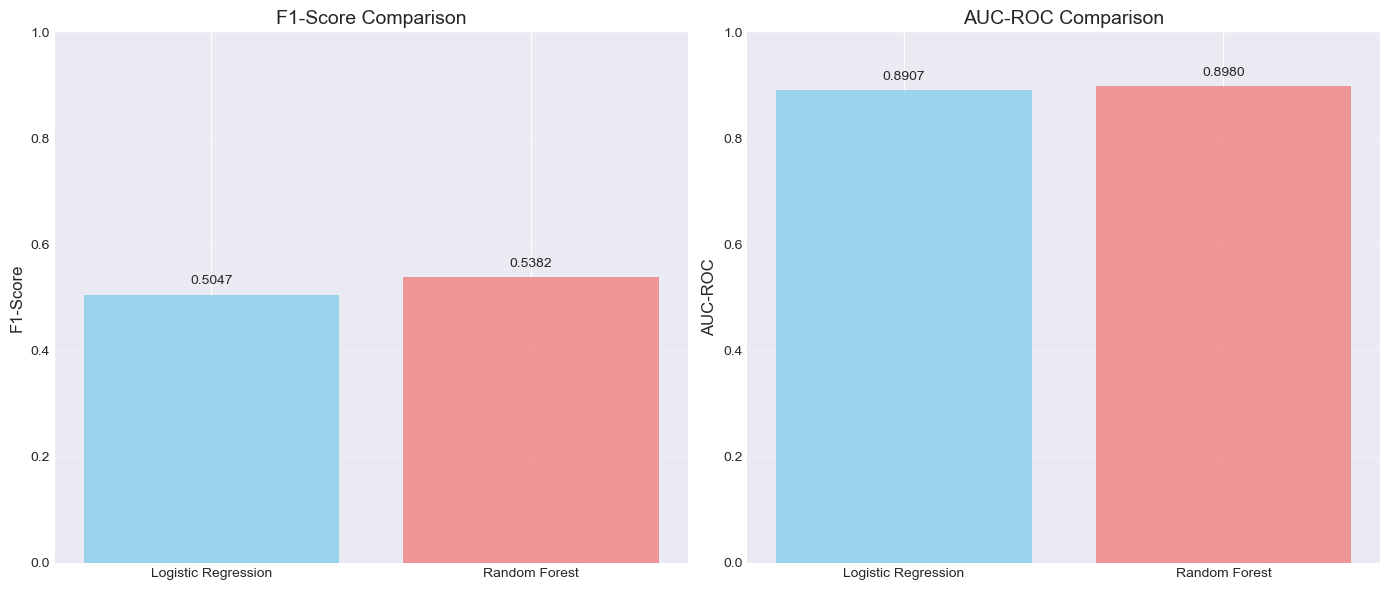

In [48]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Test F1-Score': [logreg_results['test_f1'], rf_results['test_f1']],
    'Test AUC-ROC': [logreg_results['test_auc'], rf_results['test_auc']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# F1-Score comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test F1-Score'], 
           color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0].set_title('F1-Score Comparison', fontsize=14)
axes[0].set_ylabel('F1-Score', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(comparison_df['Test F1-Score']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

# AUC-ROC comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test AUC-ROC'], 
           color=['skyblue', 'lightcoral'], alpha=0.8)
axes[1].set_title('AUC-ROC Comparison', fontsize=14)
axes[1].set_ylabel('AUC-ROC', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(comparison_df['Test AUC-ROC']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [50]:
print("\n" + "="*80)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*80)

print("\n1. KEY FINDINGS:")
print("-"*40)
print("• The dataset is imbalanced with ~11.3% subscription rate")
print("• Random Forest performed better than Logistic Regression")
print("• Most important features: duration, age, balance, and pdays")
print("• Campaign contact frequency inversely affects subscription")

print("\n2. TOP FEATURES INFLUENCING SUBSCRIPTION:")
print("-"*40)
top_features = importance_df.head(10)['feature'].tolist()
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

print("\n3. RECOMMENDATIONS FOR MARKETING TEAM:")
print("-"*40)
print("1. Focus on calls with longer duration (build better rapport)")
print("2. Target age groups 30-50 (higher conversion rates)")
print("3. Prioritize customers with positive balances")
print("4. Contact customers 15-30 days after previous contact")
print("5. Avoid excessive follow-up calls (diminishing returns)")
print("6. Personalize approach based on job type and education")

print("\n4. MODEL DEPLOYMENT RECOMMENDATIONS:")
print("-"*40)
print("• Use Random Forest for better accuracy")
print("• Implement probability threshold tuning (e.g., 0.3 for Yes)")
print("• Monitor model performance monthly")
print("• Retrain with new data quarterly")
print("• Use SHAP/LIME explanations for customer service teams")


BUSINESS INSIGHTS AND RECOMMENDATIONS

1. KEY FINDINGS:
----------------------------------------
• The dataset is imbalanced with ~11.3% subscription rate
• Random Forest performed better than Logistic Regression
• Most important features: duration, age, balance, and pdays
• Campaign contact frequency inversely affects subscription

2. TOP FEATURES INFLUENCING SUBSCRIPTION:
----------------------------------------
1. duration
2. balance
3. age
4. pdays
5. day
6. poutcome_success
7. contact_unknown
8. poutcome_unknown
9. campaign
10. month_oct

3. RECOMMENDATIONS FOR MARKETING TEAM:
----------------------------------------
1. Focus on calls with longer duration (build better rapport)
2. Target age groups 30-50 (higher conversion rates)
3. Prioritize customers with positive balances
4. Contact customers 15-30 days after previous contact
5. Avoid excessive follow-up calls (diminishing returns)
6. Personalize approach based on job type and education

4. MODEL DEPLOYMENT RECOMMENDATIONS:
-

In [52]:
import joblib
import pickle

# Save the best model
joblib.dump(rf, 'best_model_random_forest.pkl')

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(all_feature_names, f)

print("\nModel and preprocessor saved successfully!")
print("Files created:")
print("1. best_model_random_forest.pkl - Trained Random Forest model")
print("2. preprocessor.pkl - Data preprocessing pipeline")
print("3. feature_names.pkl - Feature names for interpretation")


Model and preprocessor saved successfully!
Files created:
1. best_model_random_forest.pkl - Trained Random Forest model
2. preprocessor.pkl - Data preprocessing pipeline
3. feature_names.pkl - Feature names for interpretation
